In [1]:
import numpy as np
import multinetx as mx
import matplotlib.pyplot as plt
from bluepysnap import Circuit
from scipy import sparse

In [2]:
c = Circuit('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json')

In [3]:
edges = c.edges['hippocampus_neurons__hippocampus_neurons__chemical_synapse']

In [4]:
import os
edge_features_dir = {}
for filename in os.listdir(edges.config['auxillary_edges_dir']):
    feature = filename.split('.')[0].split('__')[1]
    edge_features_dir[feature] = f"{edges.config['auxillary_edges_dir']}/{filename}"

In [21]:
for i in edge_features_dir.keys():
    print(i)

n_rrp_vesicles
decay_time
depression_time
conductance_scale_factor
u_syn
facilitation_time
conductance
delay
u_hill_coefficient


In [8]:
delayome = sparse.load_npz(edge_features_dir['delay'])

In [6]:
synaptome = sparse.load_npz(edges.config['synaptome'])

In [22]:
nrrp = sparse.load_npz(edge_features_dir['n_rrp_vesicles'])

In [23]:
conductome = sparse.load_npz(edge_features_dir['conductance']) 

In [7]:
def filter_nodeset_from_adj(adj:sparse.csc_matrix,circuit:Circuit,pop_name:str, nodeset:str):
    '''
    Filter nodeset from existing superset of adjacency matrix
    
    adj : sparse.csc_matrix loaded in the memory with shape NxN
    circuit : bluepysnap.Circuit object
    population: SONATA node population to query
    node_set : name of the nodeset in the circuit with M nodes
    
    returns
    ------
    submatrix_adj: MxM submatrix from superset
    '''
    
    subset_node_ids = circuit.nodes[pop_name].ids(nodeset)
    return adj[subset_node_ids,:][:,subset_node_ids]

In [24]:
node_set = 'slice10'
nodeset_synaptome = filter_nodeset_from_adj(synaptome,c,'hippocampus_neurons',node_set)
nodeset_delayome = filter_nodeset_from_adj(delayome,c,'hippocampus_neurons',node_set)
nodeset_nrrpome = filter_nodeset_from_adj(nrrp,c,'hippocampus_neurons',node_set)
nodeset_conductome = filter_nodeset_from_adj(conductome,c,'hippocampus_neurons',node_set)

In [27]:
g1 = mx.from_scipy_sparse_array(nodeset_synaptome)

In [34]:
N = nodeset_synaptome.shape[0]
num_features = 4

In [35]:
adj_block = mx.lil_matrix(np.zeros((N*num_features,N*num_features)))

In [ ]:
# LEFT HERE

In [22]:
adj_block[0:  N,  N:2*N] = np.identity(N)    # L_12
adj_block[0:  N,2*N:3*N] = np.identity(N)    # L_13
adj_block[N:2*N,2*N:3*N] = np.identity(N)    # L_23
    
# use symmetric inter-adjacency matrix
adj_block += adj_block.T

In [23]:
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

In [24]:
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=3)

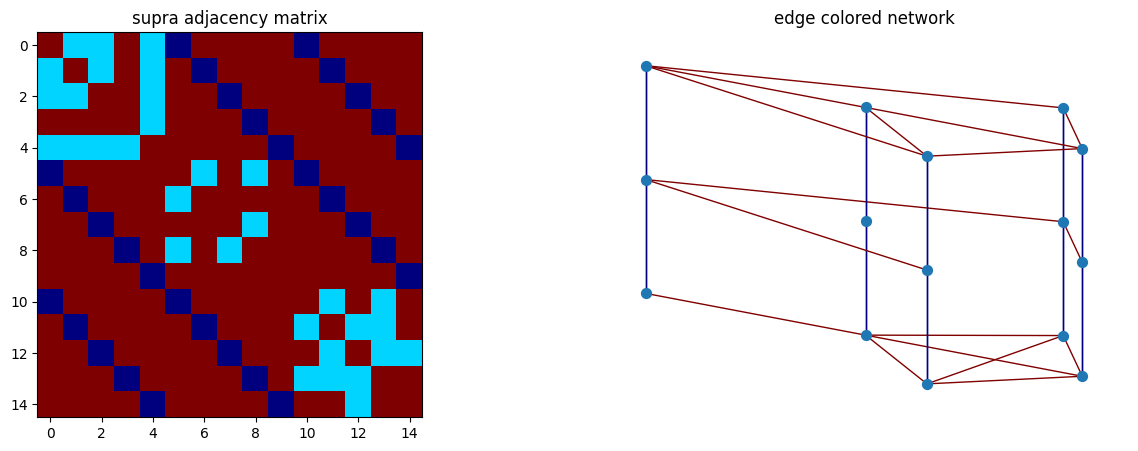

In [26]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
					  layer_vertical_shift=0.2,
					  layer_horizontal_shift=0.0,
					  proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()